<a href="https://colab.research.google.com/github/Rohit738767/Product-Recommendation-Engine/blob/main/Product_Recommendation_Engine(Team_Notebook)_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Build a recommender engine that reviews customer ratings and purchase history to recommend items and improve sales. </u></b>

### Amazon.com is one of the largest electronic commerce and cloud computing companies.

### Just a few Amazon related facts:

### They lost $4.8 million in August 2013, when their website went down for 40 mins. They hold the patent on 1-Click buying, and licenses it to Apple. Their Phoenix fulfilment centre is a massive 1.2 million square feet. Amazon relies heavily on a Recommendation engine that reviews customer ratings and purchase history to recommend items and improve sales.


### This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

### It contains

* ### the unique UserId (Customer Identification),
* ### the product ASIN (Amazon's unique product identification code for each product),
* ### Ratings (ranging from 1-5 based on customer satisfaction) and
* ### the Timestamp of the rating (in UNIX time)

### This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

### This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).


In [ ]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Beauty.csv')

In [ ]:
data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
data.drop('Timestamp',axis = 1,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


In [ ]:
data.shape

(2023070, 3)

In [ ]:
data.describe()

,Rating
count,2.023070e+06
mean,4.149036e+00
std,1.311505e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


# Due to a large dataset we limit ourself first 1048576 rows and all columns

In [ ]:
#Taking subset of the dataset
data_1 = data = data.iloc[:1048576,0:]


In [ ]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   UserId     1048576 non-null  object 
 1   ProductId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


# After we see the describe of rating the mean is less than median so the distribution is negative skewed

In [ ]:
#Summary statistics of rating variable
data_1['Rating'].describe().transpose().reset_index()

,index,Rating
0,count,1.048576e+06
1,mean,4.176861e+00
2,std,1.306546e+00
3,min,1.000000e+00
4,25%,4.000000e+00
5,50%,5.000000e+00
6,75%,5.000000e+00
7,max,5.000000e+00


In [ ]:

#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(data_1.Rating.min()))
print('Maximum rating is: %d' %(data_1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


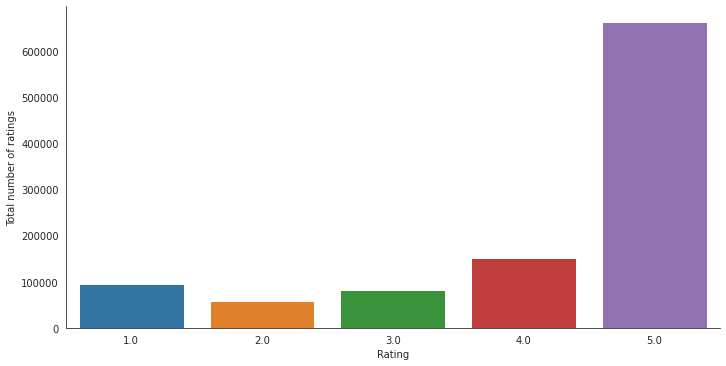

In [ ]:
# check the Rating distribution in the range 1-5 for the Data given 

with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

# Handling missing value

In [ ]:
data_1.isnull().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [ ]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', data_1['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', data_1['ProductId'].nunique())

Number of unique users in Raw data =  736654
Number of unique product in Raw data =  97987


In [ ]:
#Check the top 10 users based on ratings
most_rated=data_1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
A3M174IC0VXOS2    278
A281NPSIMI1C2R    245
A1RRMZKOMZ2M7J    200
A3KEZLJ59C1JVH    178
A2V5R832QCSOMX    173
A3R9H6OKZHHRJD    158
ALQGOMOY1F5X9     151
A2C58G8O40YC7T    145
AKMEY1BSHSDG7     144
A2Y4S4CNGKF21S    114
dtype: int64


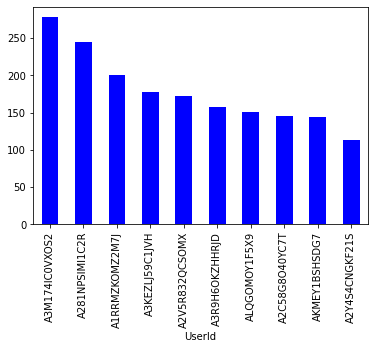

In [ ]:
most_rated.head(10).plot(kind = 'bar',color = 'blue')

In [ ]:
ratings_mean_count = pd.DataFrame(data_1.groupby('ProductId')['Rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(data_1.groupby('ProductId')['Rating'].count())

In [ ]:
ratings_mean_count.head()

,Rating,rating_counts
ProductId,,
0205616461,5.0,1
0558925278,4.0,2
0733001998,4.0,1
0737104473,1.0,1
0762451459,5.0,1


<Figure size 576x432 with 0 Axes>

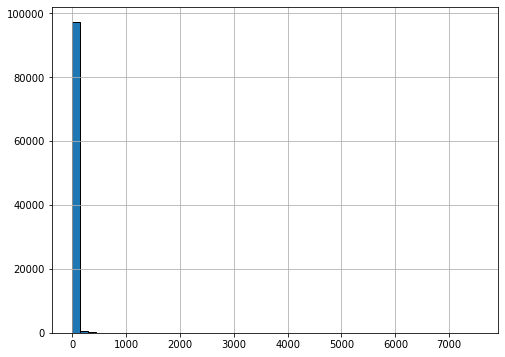

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

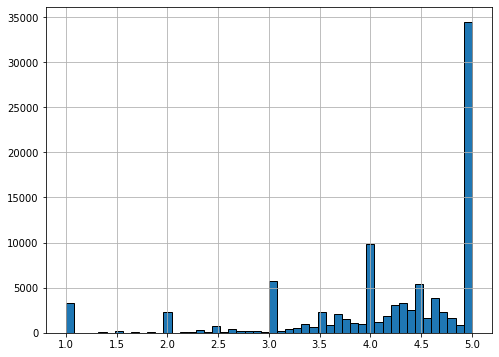

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

In [ ]:
counts=data_1.UserId.value_counts()
data_1_final=data_1[data_1.UserId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(data_1_final))
print('Number of unique users in the final data = ', data_1_final['UserId'].nunique())
print('Number of unique products in the final data = ', data_1_final['UserId'].nunique())

Number of users who have rated 25 or more items = 27475
Number of unique users in the final data =  1091
Number of unique products in the final data =  1091


In [ ]:
#constructing the pivot table
final_ratings_matrix = data_1_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
final_ratings_matrix.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10F0D8JQU9WBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_ratings_matrix.shape

(1091, 15279)

In [ ]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))


given_num_of_ratings =  27475
possible_num_of_ratings =  16669389
density: 0.16%


In [ ]:

#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(data_1_final, test_size = 0.3, random_state=0)
train_data.head()

,UserId,ProductId,Rating
545385,A2VOGNBUMXSW13,B00142E92I,3.0
726200,A24N4FKHGD7DWT,B001KYO7AY,4.0
852206,A1JAPP1CXRG57A,B002DPUY60,5.0
197947,A1RRMZKOMZ2M7J,B000C1W4HE,4.0
217502,A12YSW2P8SOLNX,B000CQPRBE,2.0


In [ ]:
train_data.shape

(19232, 3)

In [ ]:
test_data.shape

(8243, 3)

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head(40)

,ProductId,score
0,0762451459,1
1,1304139212,1
2,130414643X,1
3,1304174867,1
4,1304351475,1
5,1304482596,1
6,1304511111,1
7,1304511138,1
8,1304511154,1
9,1304622657,1


# Buliding a popularity based model

In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,score,rank
486,B000142FVW,39,1.0
5274,B000ZMBSPE,31,2.0
5967,B00150LT40,26,3.0
8451,B001OMI93S,26,4.0
10193,B002QI1F8A,25,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

       userId   ProductId  score  rank
486        10  B000142FVW     39   1.0
5274       10  B000ZMBSPE     31   2.0
5967       10  B00150LT40     26   3.0
8451       10  B001OMI93S     26   4.0
10193      10  B002QI1F8A     25   5.0


The list of recommendations for the userId: 100

       userId   ProductId  score  rank
486       100  B000142FVW     39   1.0
5274      100  B000ZMBSPE     31   2.0
5967      100  B00150LT40     26   3.0
8451      100  B001OMI93S     26   4.0
10193     100  B002QI1F8A     25   5.0


The list of recommendations for the userId: 150

       userId   ProductId  score  rank
486       150  B000142FVW     39   1.0
5274      150  B000ZMBSPE     31   2.0
5967      150  B00150LT40     26   3.0
8451      150  B001OMI93S     26   4.0
10193     150  B002QI1F8A     25   5.0




Text(0.5, 1.0, 'Ratings of product Id')

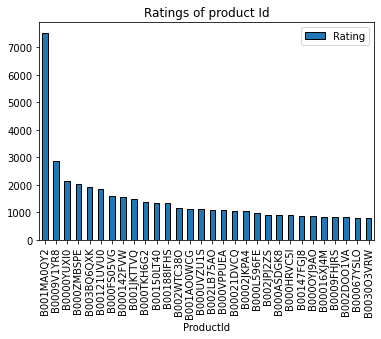

In [ ]:
# Top 30 recommendations for the users

popular_products = pd.DataFrame(data_1.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")
plt.title("Ratings of product Id")
plt.show()

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,UserId,ProductId,Rating
0,545385,A2VOGNBUMXSW13,B00142E92I,3.0
1,726200,A24N4FKHGD7DWT,B001KYO7AY,4.0
2,852206,A1JAPP1CXRG57A,B002DPUY60,5.0
3,197947,A1RRMZKOMZ2M7J,B000C1W4HE,4.0
4,217502,A12YSW2P8SOLNX,B000CQPRBE,2.0


In [ ]:

# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10F0D8JQU9WBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C,user_index
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10F0D8JQU9WBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.02080492e-02 -2.95078165e-04 -4.65353552e-03 ...  4.01395908e-03
   3.34475126e-04  6.00432865e-04]
 [ 6.27573082e-03  1.37432776e-02  9.67445448e-03 ...  3.23800650e-02
   4.79803890e-03  5.86414092e-03]
 [-8.65921227e-03  1.38038335e-03 -8.01827462e-03 ...  1.24757881e-02
  -8.27049291e-04  5.45607515e-03]
 ...
 [-2.53775477e-02 -7.01301726e-04 -1.43408284e-02 ...  1.52725206e-02
  -4.53597116e-04  5.77063312e-03]
 [-3.03946568e-02  2.36413581e-03 -1.43261765e-02 ...  2.83805352e-02
   6.21710913e-03  5.34701055e-03]
 [-1.20634323e-03  2.98522796e-05  1.07911550e-03 ...  7.96914969e-03
   1.77042151e-04  8.40677267e-04]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [51.03485004 51.29977604 51.69492842 52.71158595 54.14131801 55.13959986
 60.52803265 64.93668095 75.38206302 77.33824198]


In [ ]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[51.03485004  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         51.29977604  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         51.69492842  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         52.71158595  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         54.14131801  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         55.13959986
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  60.52803265  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         64.93668095  0.          0.        ]
 [ 0.          0.          0.        

In [ ]:

print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.32245865e-04 -8.27745974e-06 -8.27745974e-06 ... -4.53203702e-05
  -3.13824340e-03 -5.64556567e-04]
 [ 1.06427483e-03  4.41939683e-06  4.41939683e-06 ...  6.58487727e-05
  -9.24002798e-04  1.75961705e-04]
 [ 2.39553252e-03 -3.41460247e-06 -3.41460247e-06 ... -3.59084084e-05
  -3.28985162e-03 -1.14010428e-04]
 ...
 [ 3.52693053e-03  1.52657562e-05  1.52657562e-05 ...  5.38209262e-05
   3.44961073e-03  6.96547877e-04]
 [ 9.20740918e-04  5.61946749e-07  5.61946749e-07 ...  1.64050877e-04
   1.19029362e-04  3.92035475e-06]
 [ 5.68042677e-04  1.80340364e-06  1.80340364e-06 ...  6.55481841e-05
   3.55986794e-04  1.97889584e-04]]


In [ ]:

#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
0,0.001487,0.000017,0.000017,0.000017,0.000017,0.000779,0.000100,0.000100,0.000100,0.000100,0.000100,0.000017,0.000017,0.000017,0.000100,0.000100,0.000117,0.000017,0.000017,0.000017,0.000017,0.000017,0.000100,0.024059,0.001564,0.000452,0.000034,0.000212,0.000068,0.000108,0.001631,0.000068,0.000854,0.000018,0.000153,-0.007621,0.001280,-0.007621,0.000308,0.000009,...,0.000892,0.000410,0.000759,0.000333,0.003444,0.000572,0.000572,0.015061,0.000199,0.000244,0.001497,0.000708,0.000054,0.000867,0.001697,0.003177,0.000032,0.000032,0.000032,0.000032,0.000039,0.000572,0.001189,0.002081,0.000678,0.000517,0.000318,0.000480,0.001327,0.000818,0.000148,0.000144,0.000539,0.000063,0.003940,0.000057,0.012599,0.000127,0.004097,0.000760
1,0.041197,0.000010,0.000010,0.000010,0.000010,-0.000352,-0.000064,-0.000064,-0.000064,-0.000064,-0.000064,0.000010,0.000010,0.000010,-0.000064,-0.000064,-0.000054,0.000010,0.000010,0.000010,0.000010,0.000010,-0.000064,-0.010608,0.000723,0.000252,0.000165,-0.000263,0.000035,-0.000070,-0.000786,-0.000028,-0.000705,0.000017,-0.000058,-0.008958,-0.001212,-0.008958,-0.000557,-0.000183,...,-0.000079,-0.000203,0.012187,0.000244,0.089604,0.008922,0.008922,-0.003208,0.000093,0.000257,-0.000869,0.014352,0.000414,0.004044,0.000861,0.019376,-0.000004,-0.000004,-0.000004,-0.000004,-0.000005,0.008922,0.032957,0.054148,-0.000130,0.000245,0.007694,0.000263,0.000764,0.042935,-0.000116,-0.000092,-0.000491,0.009561,0.001220,0.000119,-0.004033,-0.000008,-0.004182,0.000874
2,-0.000445,0.000022,0.000022,0.000022,0.000022,0.000938,0.000094,0.000094,0.000094,0.000094,0.000094,0.000022,0.000022,0.000022,0.000094,0.000094,0.000116,0.000022,0.000022,0.000022,0.000022,0.000022,0.000094,0.022707,0.001934,0.000578,0.000296,0.000862,0.000194,0.000278,0.001882,0.000074,0.003163,0.000023,0.000229,0.005189,0.001468,0.005189,0.000662,0.000357,...,0.001005,0.000433,0.001954,0.000817,0.003471,0.000230,0.000230,0.021915,0.000356,0.000288,0.001473,-0.000188,0.000014,0.000789,0.002194,0.002794,0.000043,0.000043,0.000043,0.000043,0.000054,0.000230,-0.000356,0.014284,0.000769,0.000592,0.001556,0.000526,0.001450,0.001007,0.000582,0.000206,0.001415,-0.000308,0.005861,0.000303,0.016156,0.000191,0.005075,0.001436
3,0.001128,0.000018,0.000018,0.000018,0.000018,0.000839,0.000101,0.000101,0.000101,0.000101,0.000101,0.000018,0.000018,0.000018,0.000101,0.000101,0.000119,0.000018,0.000018,0.000018,0.000018,0.000018,0.000101,0.024386,0.001604,0.000463,0.000035,0.000227,0.000071,0.000123,0.001714,0.000072,0.001001,0.000019,0.000171,-0.008220,0.001464,-0.008220,0.000357,0.000011,...,0.000922,0.000420,0.000752,0.000378,0.003138,0.000501,0.000501,0.016325,0.000203,0.000260,0.001525,0.000670,0.000078,0.000893,0.001767,0.003159,0.000033,0.000033,0.000033,0.000033,0.000041,0.000501,0.000903,0.004866,0.000765,0.000602,0.000274,0.000490,0.001368,0.000634,0.000158,0.000147,0.000677,0.000051,0.004126,0.000064,0.013621,0.000129,0.004589,0.000770
4,0.002074,0.000034,0.000034,0.000034,0.000034,0.001364,0.000147,0.000147,0.000147,0.000147,0.000147,0.000034,0.000034,0.000034,0.000147,0.000147,0.000181,0

In [ ]:
 #Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B000142FVW                  0.0          0.118828
B00016XJ4M                  0.0          0.092640
B000HRVC5I                  0.0          0.083141
B001KYS1YM                  0.0          0.080812
B000052YM7                  0.0          0.079300


In [ ]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)



Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B000E0K7NQ                  0.0          0.156221
B000AO2NXS                  0.0          0.156215
B002MO3CG6                  0.0          0.151550
B000142FVW                  0.0          0.138665
B002QI1F8A                  0.0          0.135016


In [ ]:
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B000142FVW                  0.0          0.110224
B0002Z8QG8                  0.0          0.100663
B000F63TW0                  0.0          0.088989
B000QUM5LG                  0.0          0.082512
B00016XJ4M                  0.0          0.079089


In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10F0D8JQU9WBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
0762451459    0.004583
1304139212    0.004583
130414643X    0.004583
1304174867    0.004583
1304174905    0.004583
dtype: float64

In [ ]:

# Predicted ratings 
preds_df.head()

ProductId,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,1304511138,1304511154,1304622452,1304622657,1304622665,1304624498,1304651029,1304651088,130465110X,1304651118,1304665704,1304665720,130466578X,5357954771,6162751473,711901871X,8901110814,9746427962,9759091062,978807118X,9788071198,9788071597,9788072216,9788072488,9788073417,9788073476,9788073840,9788074421,9788075681,9788079067,...,B003GRN3OO,B003GS6598,B003GTSRIO,B003GTUXTU,B003GU09PC,B003GU2C0M,B003GU2GSK,B003GVCU62,B003GWBF9O,B003GXC16E,B003GYCTBK,B003GYDH9S,B003GYNAEU,B003GYOQPC,B003GYVTI4,B003H0U5BY,B003H1F9BY,B003H1FAHC,B003H1FAU4,B003H1FBU8,B003H1MYF8,B003H2ATMM,B003H2AU76,B003H2MR2W,B003H3KLLA,B003H3PHAK,B003H3TR9C,B003H4IIH8,B003H4VAK0,B003H60F3G,B003H623ZE,B003H67R96,B003H6C764,B003H6FN24,B003H6H6X8,B003H72NYO,B003H8180I,B003H82NBG,B003H83U36,B003H87S0C
0,0.001487,0.000017,0.000017,0.000017,0.000017,0.000779,0.000100,0.000100,0.000100,0.000100,0.000100,0.000017,0.000017,0.000017,0.000100,0.000100,0.000117,0.000017,0.000017,0.000017,0.000017,0.000017,0.000100,0.024059,0.001564,0.000452,0.000034,0.000212,0.000068,0.000108,0.001631,0.000068,0.000854,0.000018,0.000153,-0.007621,0.001280,-0.007621,0.000308,0.000009,...,0.000892,0.000410,0.000759,0.000333,0.003444,0.000572,0.000572,0.015061,0.000199,0.000244,0.001497,0.000708,0.000054,0.000867,0.001697,0.003177,0.000032,0.000032,0.000032,0.000032,0.000039,0.000572,0.001189,0.002081,0.000678,0.000517,0.000318,0.000480,0.001327,0.000818,0.000148,0.000144,0.000539,0.000063,0.003940,0.000057,0.012599,0.000127,0.004097,0.000760
1,0.041197,0.000010,0.000010,0.000010,0.000010,-0.000352,-0.000064,-0.000064,-0.000064,-0.000064,-0.000064,0.000010,0.000010,0.000010,-0.000064,-0.000064,-0.000054,0.000010,0.000010,0.000010,0.000010,0.000010,-0.000064,-0.010608,0.000723,0.000252,0.000165,-0.000263,0.000035,-0.000070,-0.000786,-0.000028,-0.000705,0.000017,-0.000058,-0.008958,-0.001212,-0.008958,-0.000557,-0.000183,...,-0.000079,-0.000203,0.012187,0.000244,0.089604,0.008922,0.008922,-0.003208,0.000093,0.000257,-0.000869,0.014352,0.000414,0.004044,0.000861,0.019376,-0.000004,-0.000004,-0.000004,-0.000004,-0.000005,0.008922,0.032957,0.054148,-0.000130,0.000245,0.007694,0.000263,0.000764,0.042935,-0.000116,-0.000092,-0.000491,0.009561,0.001220,0.000119,-0.004033,-0.000008,-0.004182,0.000874
2,-0.000445,0.000022,0.000022,0.000022,0.000022,0.000938,0.000094,0.000094,0.000094,0.000094,0.000094,0.000022,0.000022,0.000022,0.000094,0.000094,0.000116,0.000022,0.000022,0.000022,0.000022,0.000022,0.000094,0.022707,0.001934,0.000578,0.000296,0.000862,0.000194,0.000278,0.001882,0.000074,0.003163,0.000023,0.000229,0.005189,0.001468,0.005189,0.000662,0.000357,...,0.001005,0.000433,0.001954,0.000817,0.003471,0.000230,0.000230,0.021915,0.000356,0.000288,0.001473,-0.000188,0.000014,0.000789,0.002194,0.002794,0.000043,0.000043,0.000043,0.000043,0.000054,0.000230,-0.000356,0.014284,0.000769,0.000592,0.001556,0.000526,0.001450,0.001007,0.000582,0.000206,0.001415,-0.000308,0.005861,0.000303,0.016156,0.000191,0.005075,0.001436
3,0.001128,0.000018,0.000018,0.000018,0.000018,0.000839,0.000101,0.000101,0.000101,0.000101,0.000101,0.000018,0.000018,0.000018,0.000101,0.000101,0.000119,0.000018,0.000018,0.000018,0.000018,0.000018,0.000101,0.024386,0.001604,0.000463,0.000035,0.000227,0.000071,0.000123,0.001714,0.000072,0.001001,0.000019,0.000171,-0.008220,0.001464,-0.008220,0.000357,0.000011,...,0.000922,0.000420,0.000752,0.000378,0.003138,0.000501,0.000501,0.016325,0.000203,0.000260,0.001525,0.000670,0.000078,0.000893,0.001767,0.003159,0.000033,0.000033,0.000033,0.000033,0.000041,0.000501,0.000903,0.004866,0.000765,0.000602,0.000274,0.000490,0.001368,0.000634,0.000158,0.000147,0.000677,0.000051,0.004126,0.000064,0.013621,0.000129,0.004589,0.000770
4,0.002074,0.000034,0.000034,0.000034,0.000034,0.001364,0.000147,0.000147,0.000147,0.000147,0.000147,0.000034,0.000034,0.000034,0.000147,0.000147,0.000181,0

In [ ]:

# Average PREDICTED rating for each item
preds_df.mean().head()


ProductId
0762451459    0.005741
1304139212    0.000028
130414643X    0.000028
1304174867    0.000028
1304174905    0.000028
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(15279, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
0762451459,0.004583,0.005741,0
1304139212,0.004583,0.000028,1
130414643X,0.004583,0.000028,2
1304174867,0.004583,0.000028,3
1304174905,0.004583,0.000028,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0059 



In [ ]:
userID = 11
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 11):

                   user_ratings  user_predictions
Recommended Items                                
B000ZMBSPE                  0.0          0.230480
B002QI1F8A                  0.0          0.215180
B0030HKJ8I                  0.0          0.202948
B000142FVW                  0.0          0.193515
B001ET76EY                  0.0          0.157505


# Conclusion 
# After such analysis by dataset we build popularity based and collabratve filtering. In popularity based you seen that there top 5 populartiy product are seen but in the recommended is similar to all the user becuase is popularity based .After that we used collabarative filtering we see that every user as different recommendation, because the collabrative filtering is used by past history of user so it will recommend by it past history